# Particles tracking

In [386]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd

mpl.rc('figure',  figsize=(12, 6))
mpl.rc('image', cmap='gray')

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb

import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'


# fps = int(cap.get(cv2.CAP_PROP_FPS))

#Функция обнаружения частиц
def detect_objects(file_path, n_frames=5, step=1, show_images=False, object_size_min=150, object_size_max=300):
    
    """Function to detect moving objects, store itheir positions, sizes and orientations
        параметр show_image - для визуализации шагов (grayscale, binarization, object detection)
    """
    # переменные для использования в последующих функциях
    global FILE_PATH 
    global N_FRAMES
    global STEP
    
    FILE_PATH = file_path
    N_FRAMES = n_frames
    STEP = step
    
    # листы для записи значений
    centroid = []
    orient = []
    bbox = []
    area = []
    major_axis = []

    file_name = [file for file in os.listdir(FILE_PATH) if 'avi' in file] # находим имя файла

    cap = cv2.VideoCapture(FILE_PATH+file_name[0]) # запускает считыватель видео
    print('Total number of frames: {}'.format(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))))
    print('Frames that will be processed: {}'.format(int(N_FRAMES/STEP)))
    count = 0
    while (True):
        ret, frame = cap.read()
        if count == 0:
            cv2.imwrite(FILE_PATH+'frame_0.jpg', frame) # сохраняем первый кадр
        count += 1
        if count >= n_frames: # прерывание, когда дошли до заданного кол-ва кадров
            break
        if count%step != 0: # шаг кадров
            continue

        image = frame
        image = cv2.GaussianBlur(image,(3,3),0) # для лучшего определния границ
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # переводим в монохром
        if show_images:
            plt.figure(figsize=(12, 8))
            plt.imshow(gray)
            plt.axis('off')
        bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1] # binarize image
        if show_images:
            plt.figure(figsize=(12, 8))
            plt.imshow(bw)
            plt.axis('off')
        cleared = clear_border(bw) # не смотрим объекты у границ
        label_image = label(cleared) # присваиваем лэйблы объектам
        image_label_overlay = label2rgb(label_image, image=image, bg_label=0) # для окрашивания
        
        if show_images:
            fig, ax = plt.subplots(figsize=(12, 8))
            ax.imshow(image_label_overlay)
            ax.axis('off')

        center = []
        ornt = []
        box = []
        a = []
        axis = []

        for region in regionprops(label_image): 
            # игнорируем мусор и очень большие элементы
            if (region.area > object_size_min) & (region.area < object_size_max): 
                minr, minc, maxr, maxc = region.bbox
                if show_images:
                    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                              fill=False, edgecolor='red', linewidth=2) # draw bounding boxes
                    ax.add_patch(rect)
                center.append(region.centroid) # center
                ornt.append(region.orientation) # orientation
                box.append([minr, minc, maxr, maxc]) # bounding box
                a.append(region.area) # object area
                axis.append(region.major_axis_length) # axis_length

        #plt.savefig('frame_'+str(count)+'.jpg')
        #plt.close()
        centroid.append(center)
        orient.append(ornt)
        bbox.append(box)
        area.append(a)
        major_axis.append(axis)
        #ax.set_axis_off()
        #plt.tight_layout()

    cap.release()
    cv2.destroyAllWindows()
    return centroid, orient, bbox, area, major_axis

In [397]:
#Функция отрисовки траекторий
def draw_trajectories(centroid, orient, area, major_axis, distance_threshold=10):

    initial_frame = cv2.cvtColor(cv2.imread(FILE_PATH+'frame_0.jpg'), cv2.COLOR_BGR2GRAY) # grab initial frame

    path = [[(x,y)] for x,y in centroid[0]]
    orientation = [[i] for i in orient[0]]
    size = [[i] for i in area[0]]
    axis_length = [[i] for i in major_axis[0]]

    for frame in range(1, int(N_FRAMES/STEP)-1): # for all frames
        for obj in range(len(centroid[frame])): # for all objects
            x,y = centroid[frame][obj]
            ornt = orient[frame][obj]
            a = area[frame][obj]
            ax = major_axis[frame][obj]
            for i in range(len(path)):
                distance = np.sqrt((path[i][-1][0]-x)**2 +(path[i][-1][1]-y)**2) # distance frame 'n' and frame 'n-1'
                if distance<distance_threshold: # если меньше порога, то одна и та же частица
                    path[i].append((x,y))
                    orientation[i].extend([ornt])
                    size[i].extend([a])
                    axis_length[i].extend([ax])

    tracks = [list(zip(*p)) for p in path]

    plt.figure(figsize=(14,10))
    plt.imshow(initial_frame, cmap=plt.cm.gray)
    for track in tracks:
        plt.plot(track[1], track[0], c='r')
        
    return tracks, orientation, size, axis_length

In [392]:
file_path = 'dense_system/part2/'
n_frames = 300
step = 1

centroid, orient, bbox, area, major_axis = detect_objects(file_path=file_path, 
                                                          n_frames=n_frames, 
                                                          step=step, 
                                                          show_images=False, 
                                                          object_size_min=110, 
                                                          object_size_max=480)

Total number of frames: 330
Frames that will be processed: 300


In [396]:
len(centroid)

299

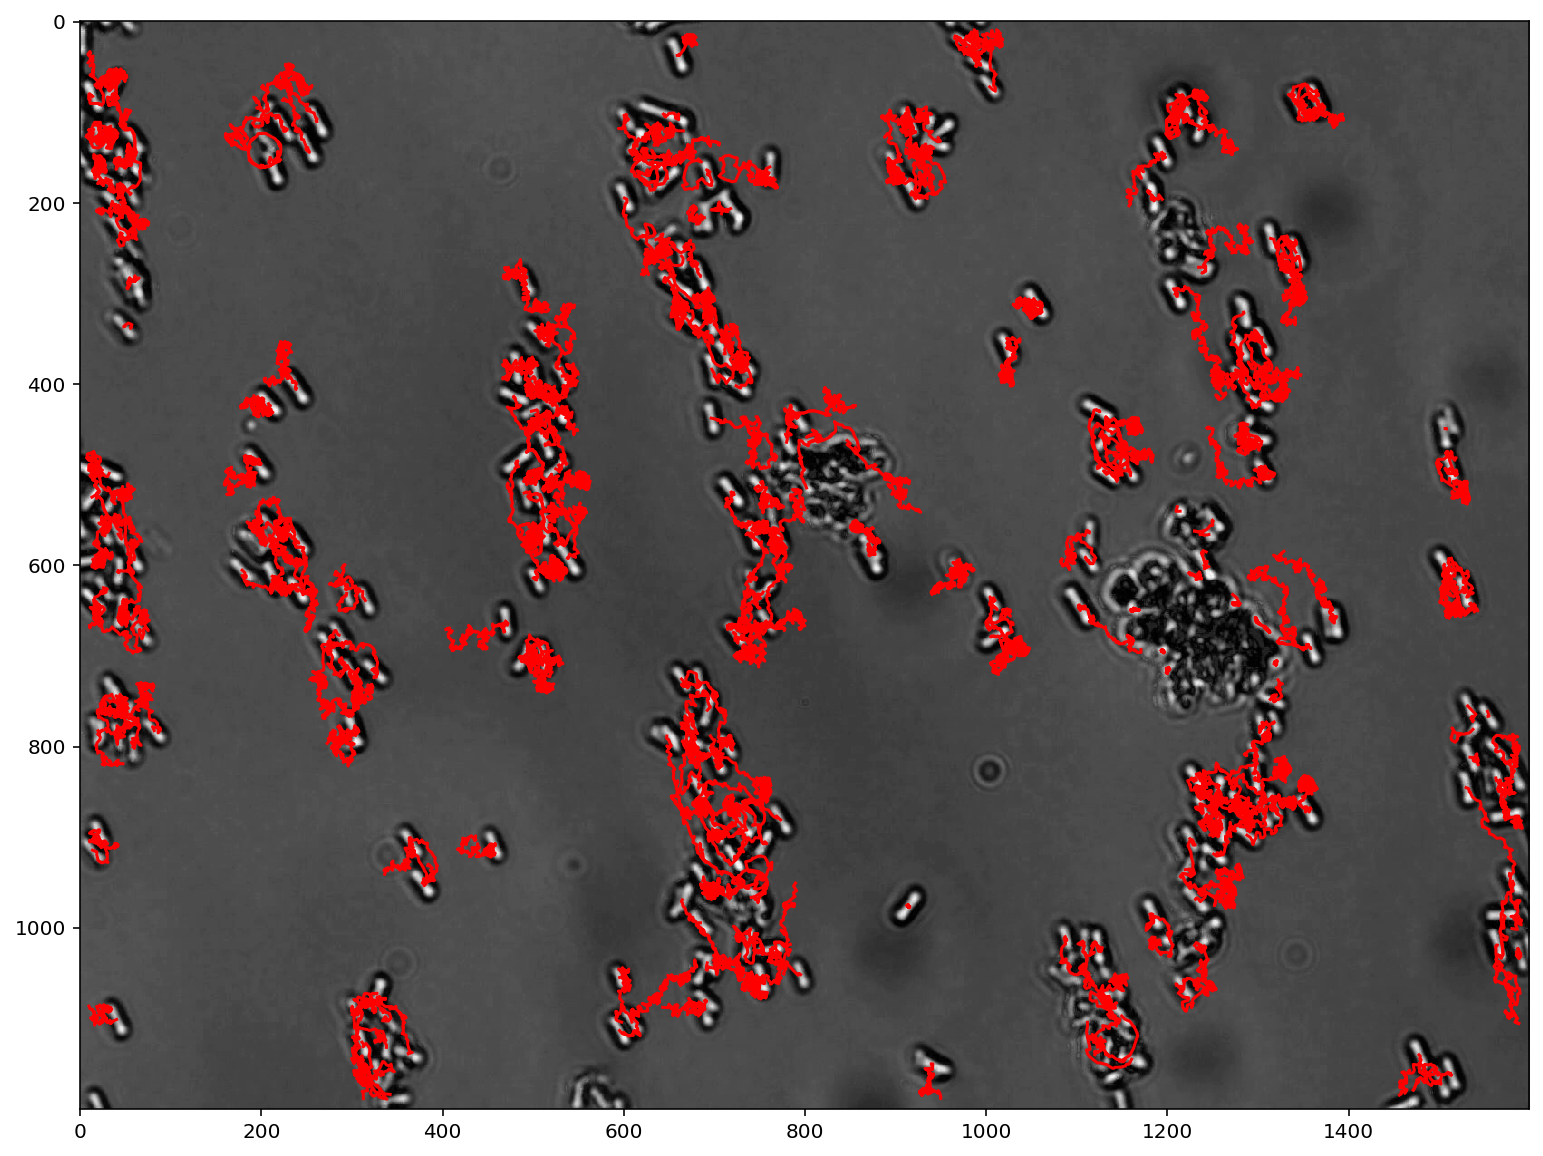

In [441]:
tracks, orientation, size, axis_length = draw_trajectories(centroid, orient, area, major_axis, distance_threshold=7)

### График для траекторий

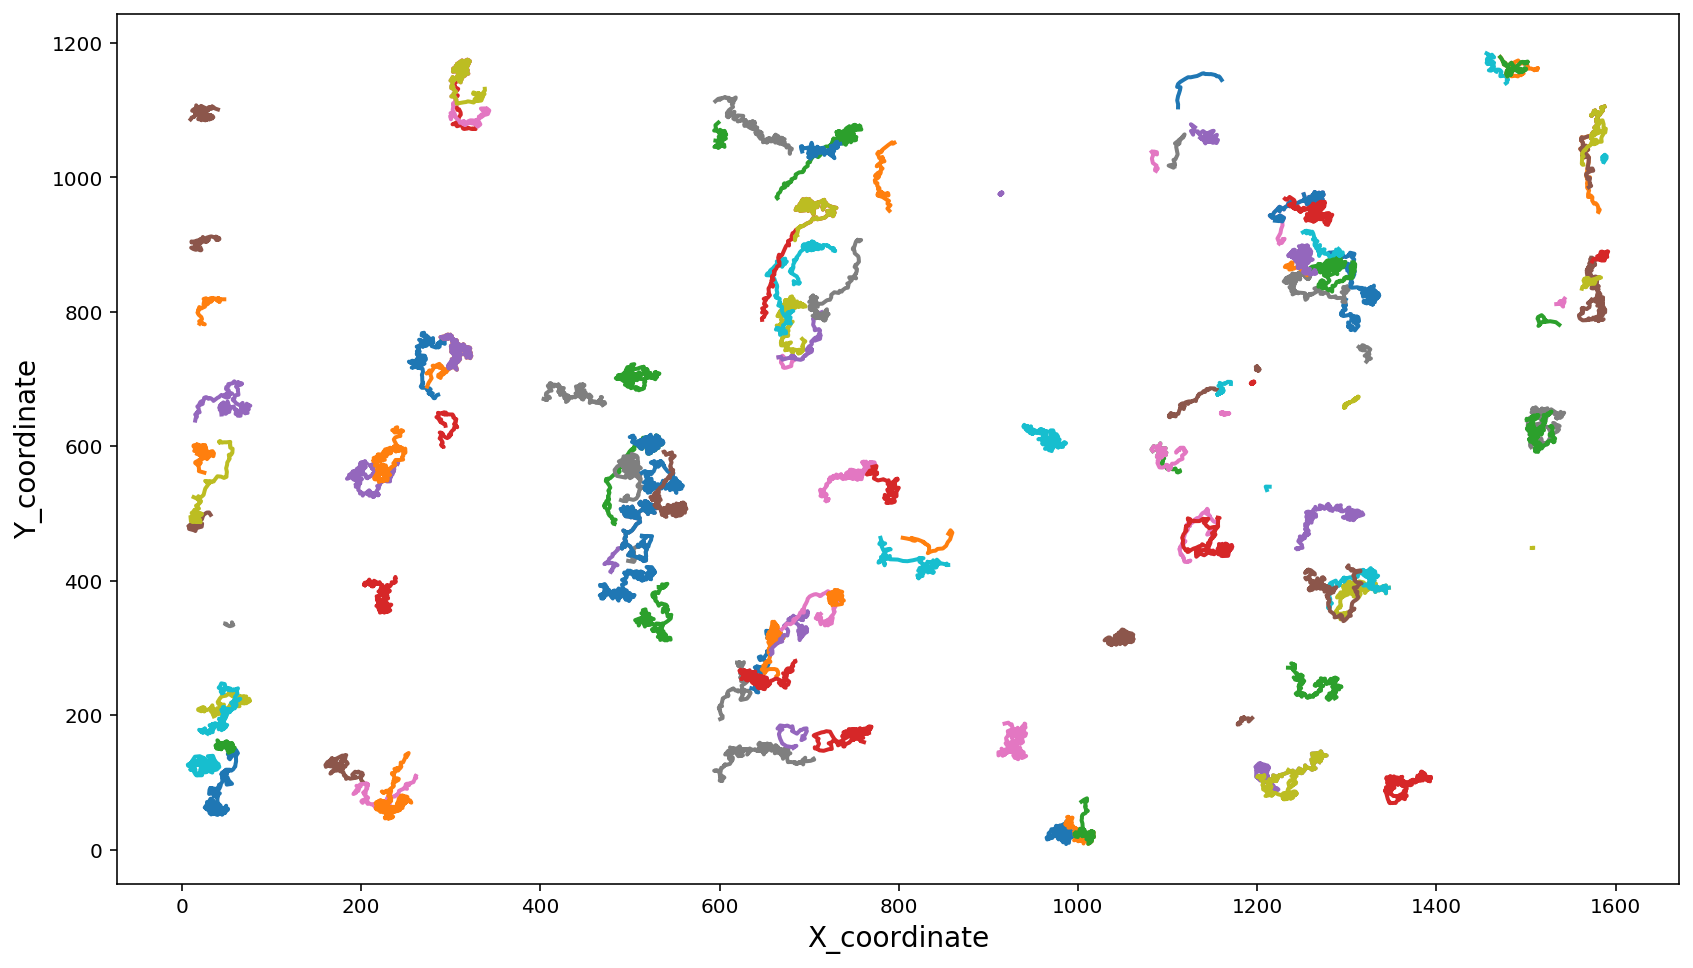

In [442]:
plt.figure(figsize=(14,8))
for i in range(0,len(tracks),2):
    plt.plot(tracks[i][1], tracks[i][0], lw=2, label='particle_{}'.format(i))
    plt.xlabel('X_coordinate', fontsize=14)
    plt.ylabel('Y_coordinate', fontsize=14)
    #plt.axis([-5, 100, -100, 100])
    #plt.legend(loc=1, fontsize=13)

### График для углов

Оставим только те частицы, по которым много информации о перемещении

In [452]:
(np.array([len(i) for i in orientation])>100).sum()

171

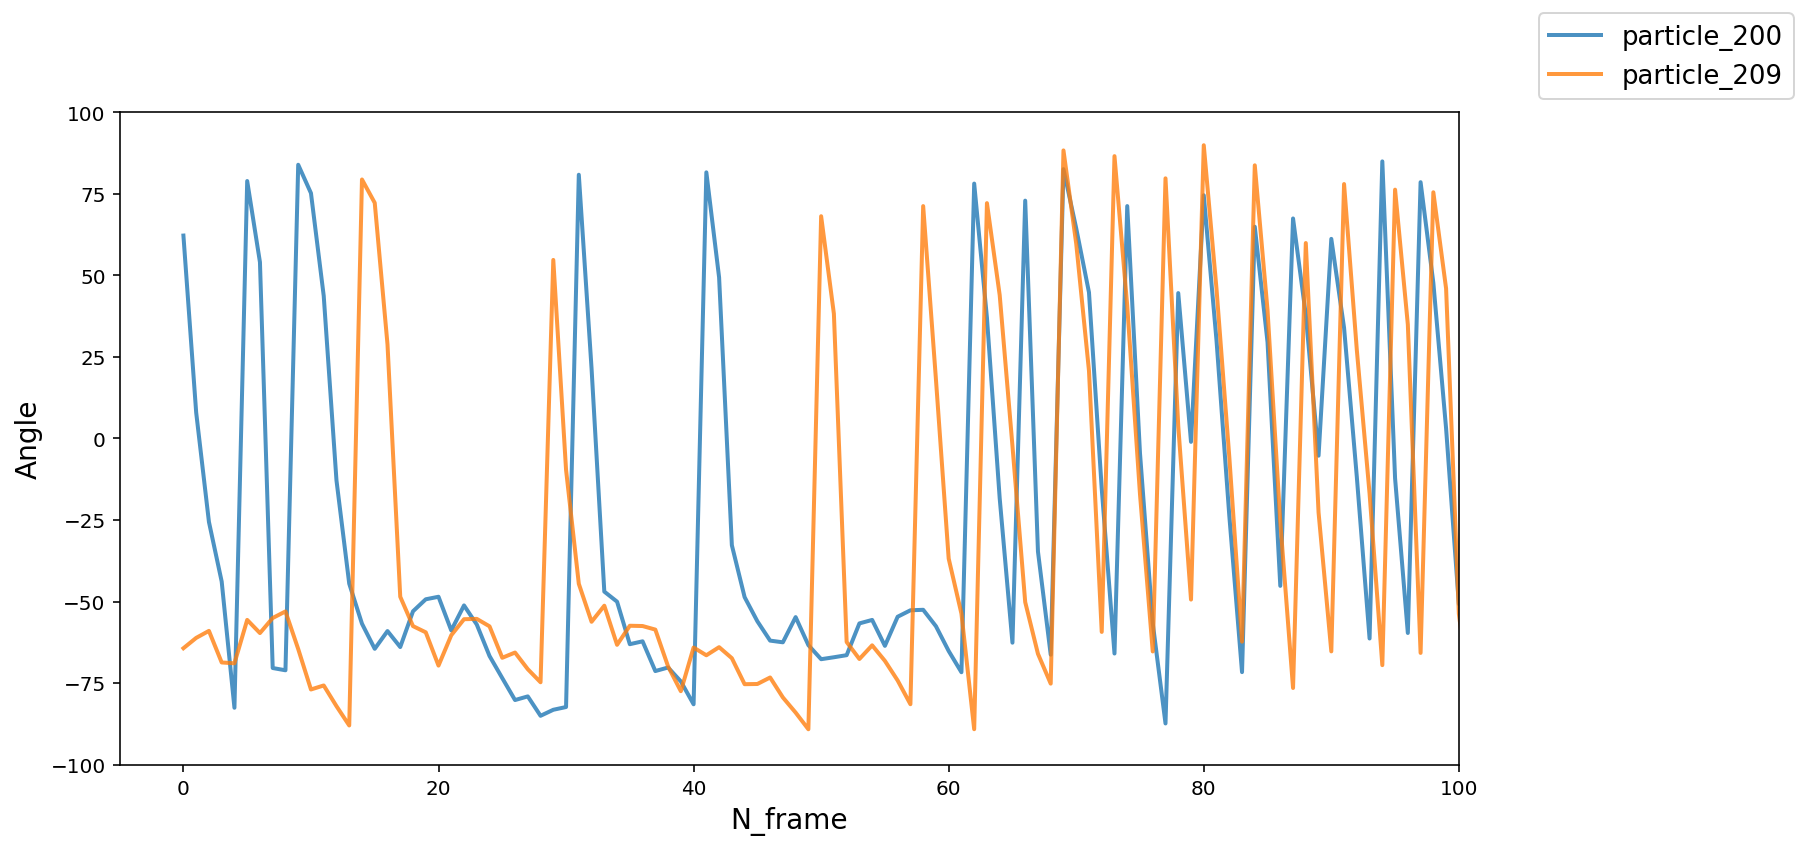

In [453]:
#Визуализация угла поворота частиц
orientation_selected = [i for i in orientation if len(i)>100]

for i in np.random.randint(0, len(orientation), 2):
    plt.plot(np.arange(len(orientation[i])), np.array(orientation[i])*180/np.pi, 
             lw=2, alpha=0.8, label='particle_{}'.format(i))
    plt.xlabel('N_frame', fontsize=14)
    plt.ylabel('Angle', fontsize=14)
    plt.axis([-5, 100, -100, 100])
    plt.legend(loc=0, fontsize=13, bbox_to_anchor=(1.05, 1))

### Расчет скоростей

In [484]:
velocity = pd.DataFrame(columns = [str(i) for i in range(len(orientation_selected))])
for i in range(len(orientation_selected)):
    velocity[str(i)] = pd.Series(orientation_selected[i]).diff()
    
velocity.fillna(method='ffill', inplace=True)
velocity.dropna(inplace=True)
velocity = velocity.applymap(lambda x: np.pi-x if x > 1 else x)
velocity = velocity.iloc[50:]

In [487]:
velocity.head()

,0,1,2,3,4,5,6,7,8,9,...,161,162,163,164,165,166,167,168,169,170
51,0.026217,-0.694525,-0.493415,-0.424629,-0.094417,-0.076430,-0.220198,-1.031002,-0.110768,0.056081,...,-0.572376,-0.198206,-0.542434,-0.571505,0.089883,-0.145914,-0.087788,-0.984442,-0.127659,-0.224397
52,-0.345939,-0.981662,1.393277,1.777204,-0.147852,-0.064605,-0.386043,-0.820309,-0.515823,-0.044402,...,1.520327,-0.088985,-1.166337,0.694996,-0.114849,0.328718,-0.044161,-0.396532,-0.117846,-0.284869
53,-0.295982,0.356943,-0.698076,-0.486945,0.360666,-0.080885,-0.708486,0.717786,0.452237,-0.053310,...,-0.419701,-0.050170,-0.826505,-2.019745,0.038637,-0.029252,-0.554499,-0.325827,1.667670,-0.287084
54,0.058176,0.412950,0.524483,-0.896006,-0.385519,0.029123,-0.628763,-0.976243,-0.992657,-0.141835,...,2.045618,0.311197,1.052506,0.606299,-0.170705,0.032325,0.426597,0.126813,-0.532270,-0.114492
55,-0.218367,0.524870,-0.583363,-1.084749,-0.988488,0.100601,-0.384504,1.701492,-0.924576,0.534859,...,-0.433292,-0.448530,-0.565378,-0.592343,-0.000206,-0.117371,-1.004931,-0.031579,-0.419988,0.241305


Text(0.5, 0, 'Velocity [rad/frame]')

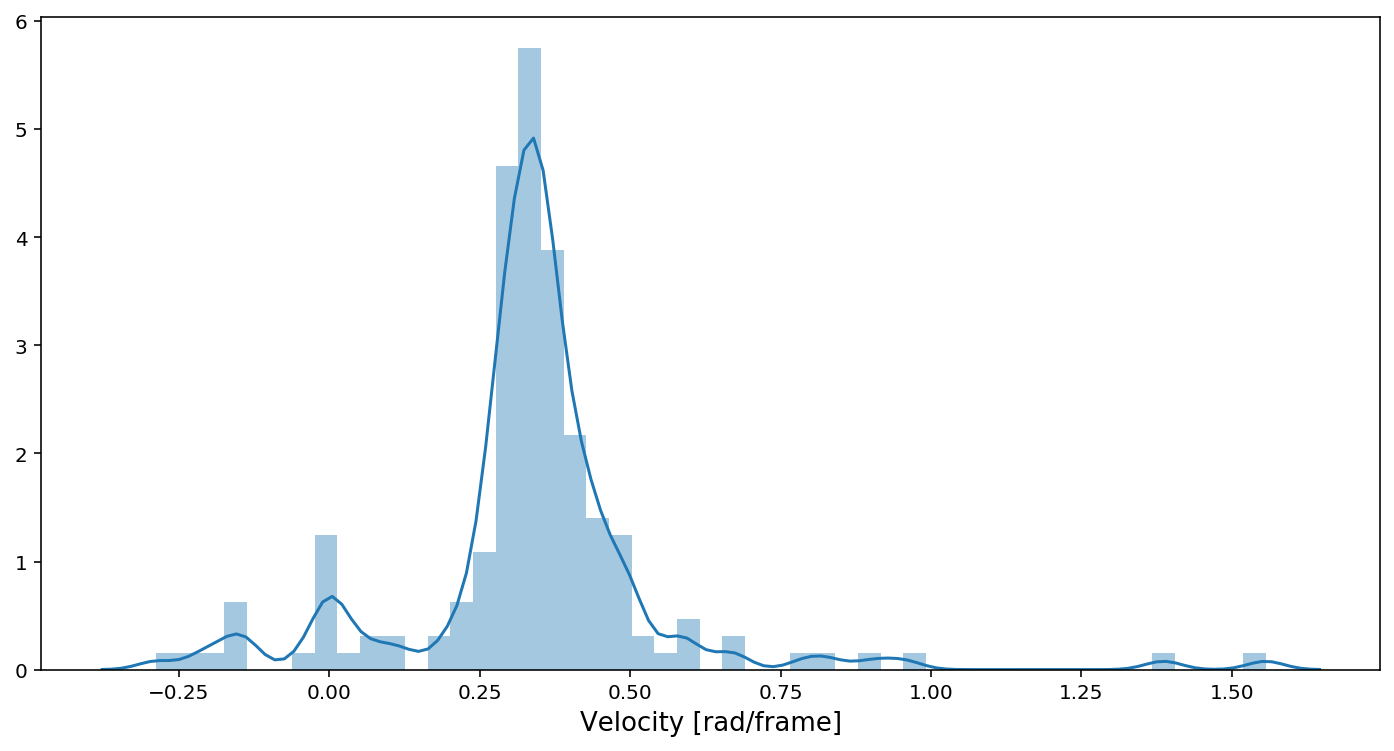

In [488]:
sns.distplot(-velocity.mean(skipna=True))
plt.xlabel('Velocity [rad/frame]', fontsize=13)

Text(0.5, 0, 'Velocity [rad/frame]')

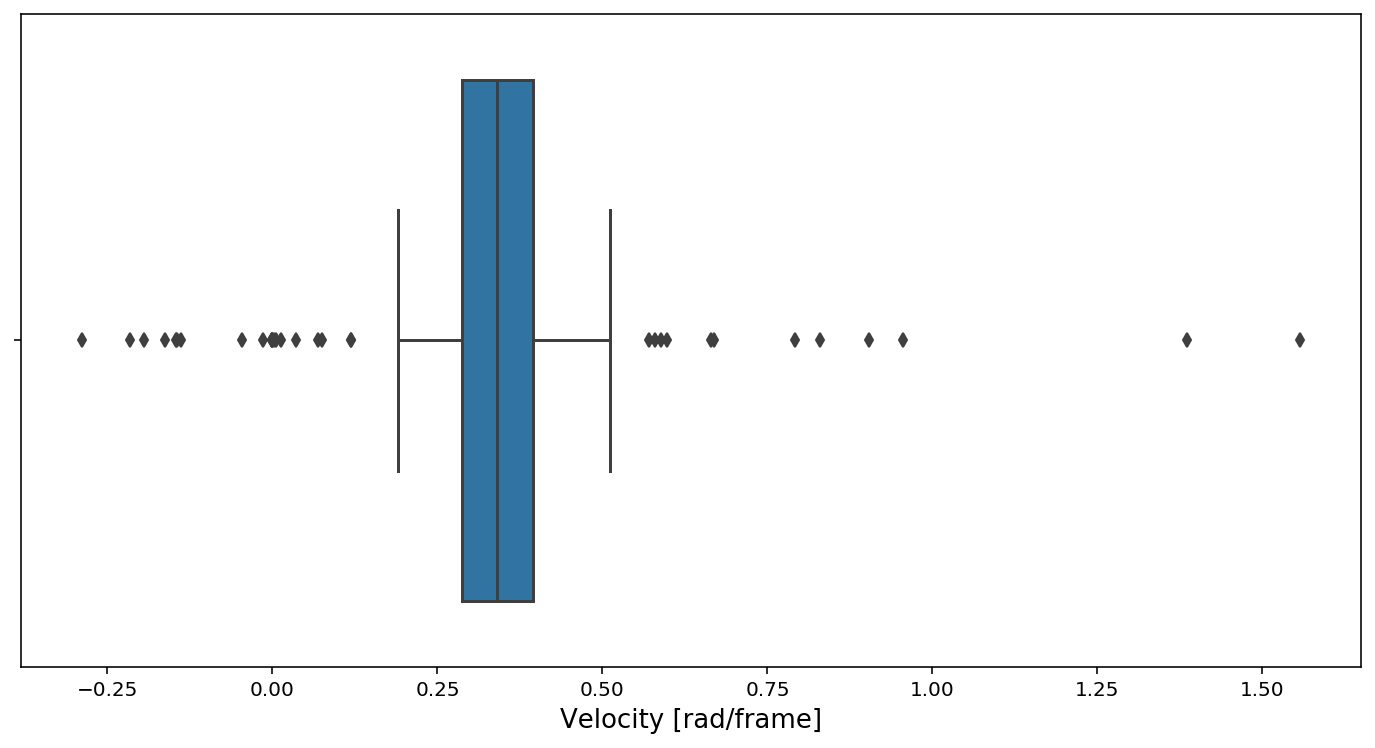

In [490]:
sns.boxplot(-velocity.mean(skipna=True))
plt.xlabel('Velocity [rad/frame]', fontsize=13)

In [374]:
np.array([(np.mean(i)*0.0922)**2 for i in axis_length])

array([14.86584246, 11.24135261,  9.4336474 , 10.3473195 , 10.13420098,
        8.78353397, 11.1222669 ,  8.21869703,  9.20735603, 11.90801718])

In [378]:
np.array([np.mean(i)*0.0922**2 for i in size]), np.array([np.std(i)*0.0922**2 for i in size])

(array([1.97015468, 1.5809489 , 1.4674464 , 1.56373988, 1.67282906,
        1.3750627 , 1.64848289, 1.38963231, 1.56602474, 1.84767386]),
 array([0.07101928, 0.05973779, 0.06096549, 0.08004013, 0.09432107,
        0.0606831 , 0.06355021, 0.07312819, 0.06588284, 0.10513816]))

In [75]:
velocity.to_excel('velocities.xlsx')